In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import Global
import joblib
import plotly.express as px
import shap
import numpy as np
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

/var/folders/9j/h9cvqwwx1c78h1ymykk4wh6w0000gn/T/ipykernel_13555/1911979401.py:21: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



                   Model        MAE       RMSE       MAPE
0               CatBoost   8.846351  14.877082  13.917586
1                    KRR   9.363876  15.259865  15.366338
2                  Lasso   9.356644  15.374008  15.632715
3       LinearRegression   9.334270  15.365014  15.611823
4           MLPRegressor  31.089343  35.346082  53.234544
5  RandomForestRegressor   9.948158  15.627824  17.293276
6                  Ridge   9.331312  15.362952  15.609791
7                    SVR   8.850551  15.302162  13.854137
8                XGBoost   8.966176  15.079994  14.317079
9                    kNN  10.681481  17.177909  19.592290


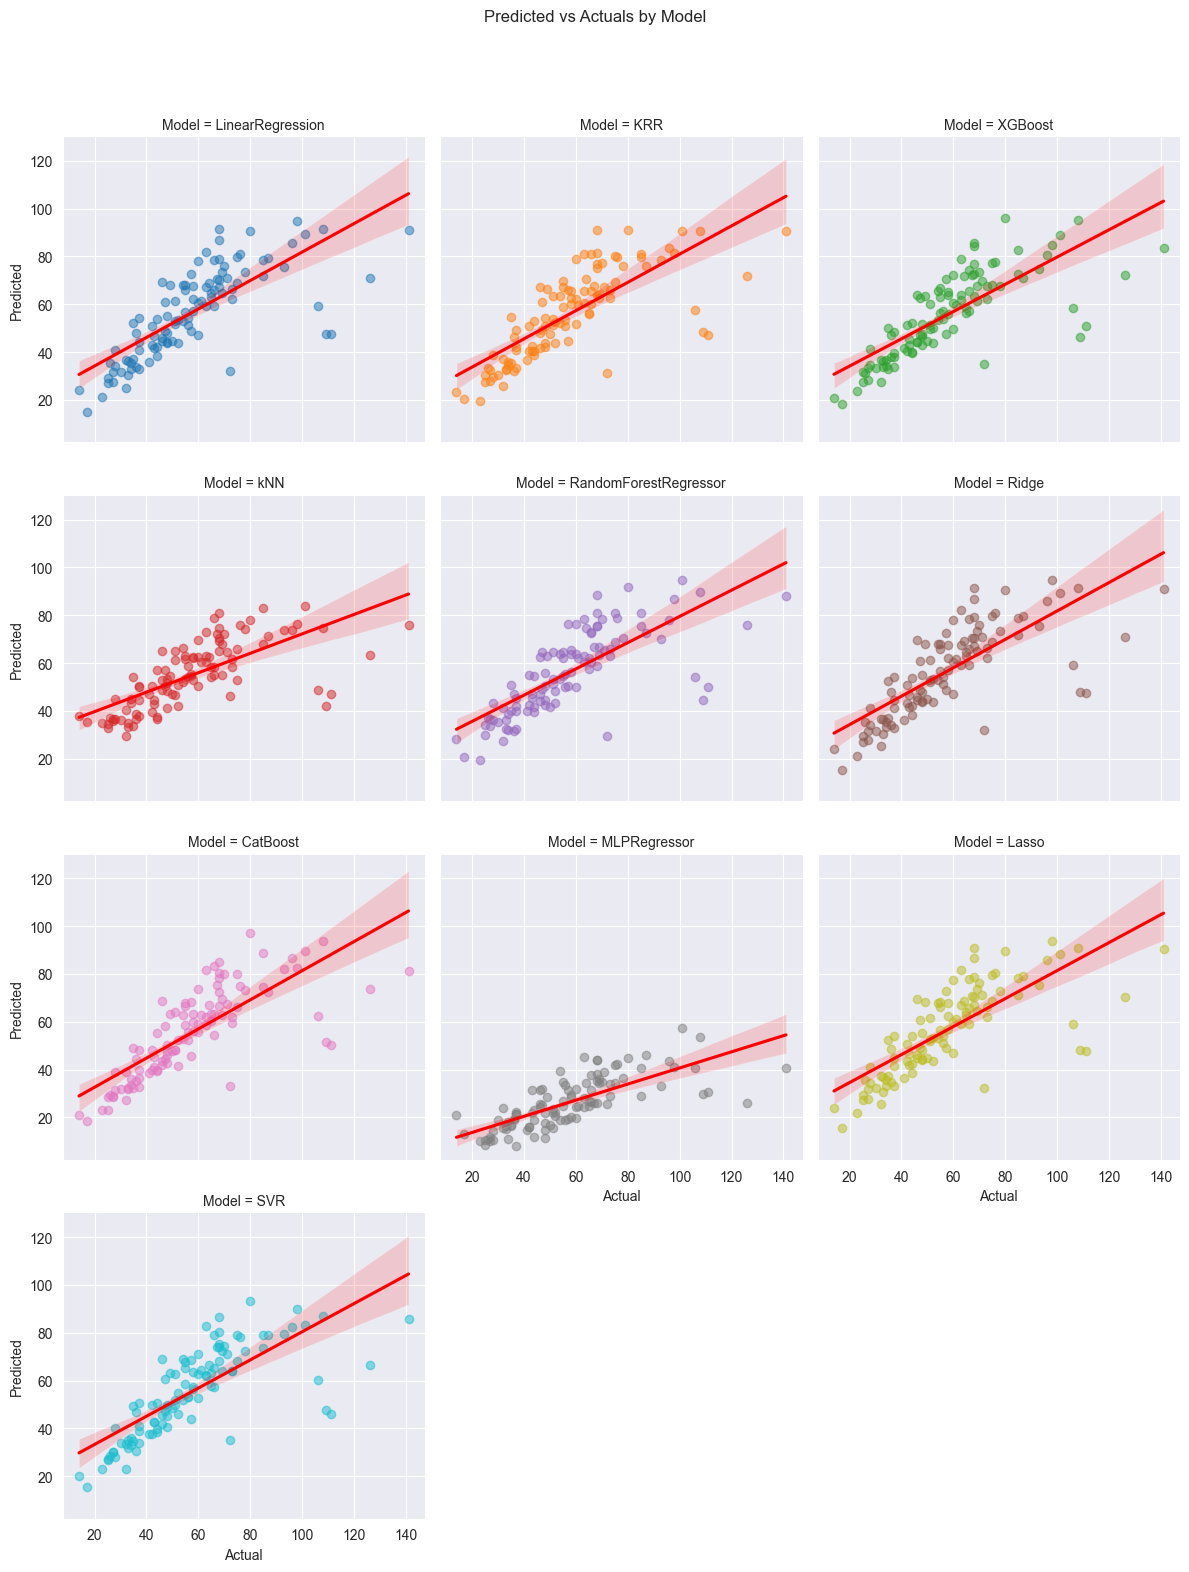

In [19]:
config = Global.load_config()
output_dir = Global.get_project_path(config["model"]["data_prep"]["path"], 0)

csv_files = list(output_dir.glob("*_predictions_vs_actuals.csv"))
eval_data = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

summary = eval_data.groupby("Model").apply(
    lambda df: {
        "MAE": (df["Actual"] - df["Predicted"]).abs().mean(),
        "RMSE": ((df["Actual"] - df["Predicted"]) ** 2).mean() ** 0.5,
        "MAPE": (abs(df["Actual"] - df["Predicted"]) / df["Actual"]).mean() * 100
    }
).apply(pd.Series).reset_index()

print(summary)

g = sns.lmplot(
    data=eval_data, x="Actual", y="Predicted",
    hue="Model", col="Model", col_wrap=3,
    height=4, scatter_kws={"alpha": 0.5}, line_kws={"color": "red"}
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Predicted vs Actuals by Model")
plt.show()

fig_weather = px.box(
    eval_data,
    x="Weather",
    y="Predicted",
    color="Weather",
    points="all",
    hover_data=eval_data.columns,
    title="Predicted Delivery Time by Weather",
    labels={"Predicted": "Predicted Delivery Time (min)"}
)
fig_weather.update_layout(template="plotly_dark")
fig_weather.show()

eval_data["Error"] = eval_data["Predicted"] - eval_data["Actual"]
fig_error = px.violin(
    eval_data,
    x="Weather",
    y="Error",
    color="Weather",
    box=True,
    points="all",
    hover_data=eval_data.columns,
    title="Prediction Error by Weather",
    labels={"Error": "Prediction Error (Predicted - Actual)"}
)
fig_error.update_layout(template="plotly_dark")
fig_error.show()



In [27]:

model_name = "CatBoost"

config = Global.load_config()
output_dir = Global.get_project_path(config["model"]["data_prep"]["path"], 0)

model = joblib.load(output_dir / f"{model_name}_best_model.joblib")
X_train = pd.read_csv(output_dir / f"X_{model_name}_train.csv")
y_train = pd.read_csv(output_dir / f"y_{model_name}_train.csv").iloc[:, 0]

if "catboost" in model_name.lower():
    categorical_cols = config["model"]["features"]["categorical"]
    for col in categorical_cols:
        if col in X_train.columns:
            X_train[col] = X_train[col].astype("category")

if "catboost" in model_name.lower():
    importance = model.get_feature_importance(type='FeatureImportance')
else:
    importance = model.feature_importances_

fi_df = pd.DataFrame({"Feature": X_train.columns, "Importance": importance})
fi_df = fi_df.sort_values("Importance", ascending=True)

fig = go.Figure()

fig.add_trace(go.Bar(
    y=fi_df['Feature'],
    x=fi_df['Importance'],
    orientation='h',
    marker=dict(
        color=fi_df['Importance'],
        colorscale='Viridis',
        line=dict(color='rgba(0,0,0,0.8)', width=1.5),
        showscale=True
    ),
    text=[f"{v:.2f}" for v in fi_df['Importance']],
    textposition='outside',
    hovertemplate='<b>%{y}</b><br>Importance: %{x:.2f}<extra></extra>'
))


fig.update_layout(
    title=f"✨ Feature Importance - {model_name}",
    template='plotly_dark',
    xaxis=dict(title='Importance', showgrid=True, gridcolor='rgba(255,255,255,0.1)'),
    yaxis=dict(title='', tickfont=dict(size=13)),
    font=dict(family="Helvetica", size=14),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    height=800,
    margin=dict(l=200, r=50, t=100, b=50)
)

fig.show()




In [14]:
model_name = "CatBoost"


config = Global.load_config()
output_dir = Global.get_project_path(config["model"]["data_prep"]["path"], 0)


model = joblib.load(output_dir / f"{model_name}_best_model.joblib")
X_train = pd.read_csv(output_dir / f"X_{model_name}_train.csv")
y_train = pd.read_csv(output_dir / f"y_{model_name}_train.csv").iloc[:, 0]


categorical_cols = config["model"]["features"]["categorical"]
for col in categorical_cols:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype("category")


explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_train)


shap_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Mean_ABS_SHAP": np.abs(shap_values).mean(axis=0)
}).sort_values("Mean_ABS_SHAP", ascending=True)


fig = px.bar(
    shap_importance,
    x="Mean_ABS_SHAP",
    y="Feature",
    orientation='h',
    color="Mean_ABS_SHAP",
    color_continuous_scale='Viridis',
    text=shap_importance['Mean_ABS_SHAP'].apply(lambda x: f"{x:.3f}")
)

fig.update_layout(
    title=f"🌟 SHAP Feature Importance - {model_name}",
    template='plotly_dark',
    xaxis=dict(title='Mean |SHAP value|'),
    yaxis=dict(title='', tickfont=dict(size=13)),
    font=dict(family="Helvetica", size=14),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    height=800,
    margin=dict(l=200, r=50, t=100, b=50)
)

fig.update_traces(textposition='outside')

fig.show()



/var/folders/9j/h9cvqwwx1c78h1ymykk4wh6w0000gn/T/ipykernel_13555/3141926913.py:18: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



                   Model        MAE       RMSE       MAPE
0               CatBoost   8.846351  14.877082  13.917586
1                    KRR   9.650822  15.690188  15.966085
2                  Lasso   9.356644  15.374008  15.632715
3       LinearRegression   9.334270  15.365014  15.611823
4           MLPRegressor  31.089343  35.346082  53.234544
5  RandomForestRegressor  10.110222  15.877843  17.533486
6                  Ridge   9.331312  15.362952  15.609791
7                    SVR   8.712979  15.061554  13.433832
8                XGBoost   8.966176  15.079994  14.317079
9                    kNN  10.137662  16.103803  17.162103


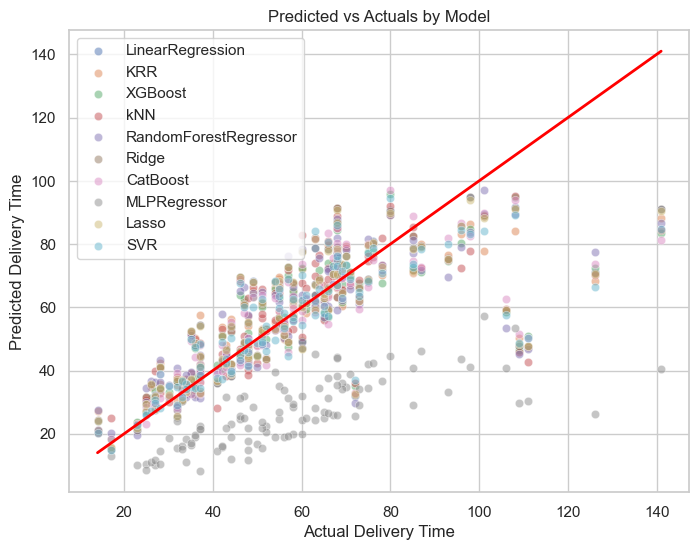

/var/folders/9j/h9cvqwwx1c78h1ymykk4wh6w0000gn/T/ipykernel_13555/3141926913.py:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




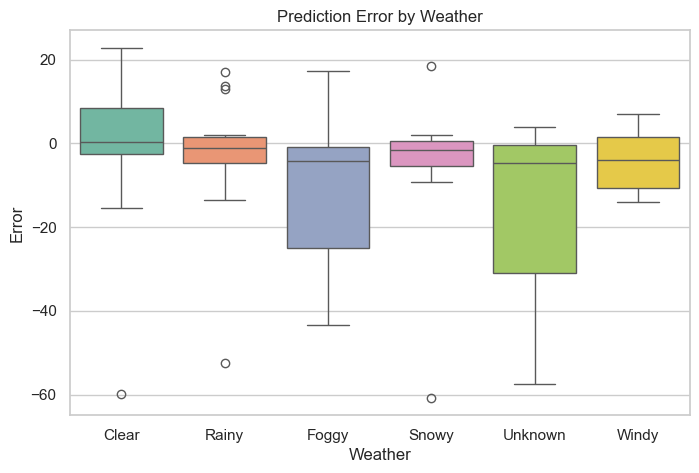

/var/folders/9j/h9cvqwwx1c78h1ymykk4wh6w0000gn/T/ipykernel_13555/3141926913.py:51: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




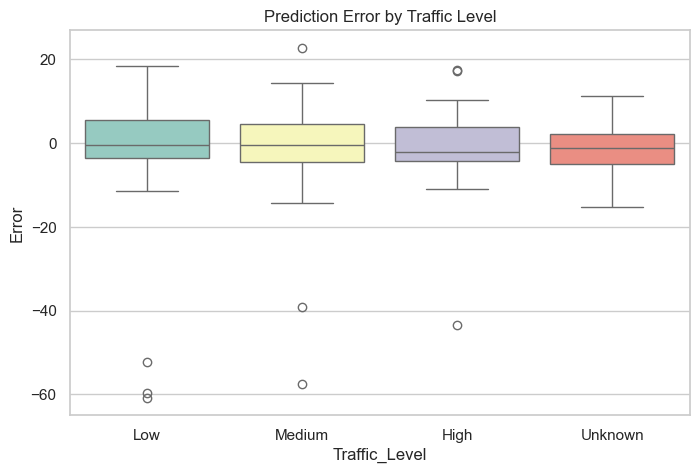

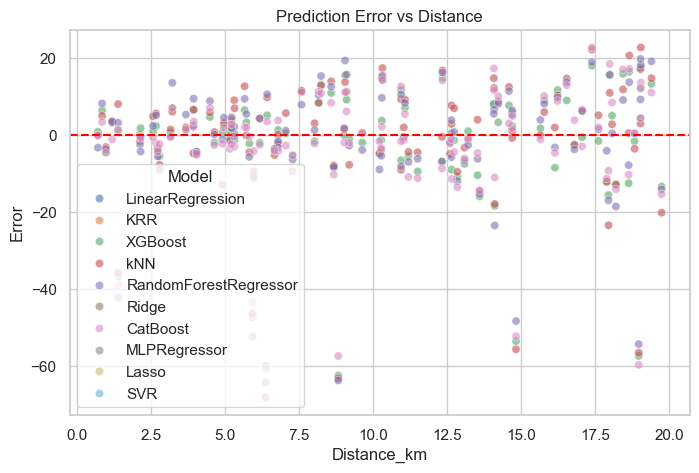

In [25]:

config = Global.load_config()
output_dir = Path(Global.get_project_path(config["model"]["data_prep"]["path"], 0))

csv_files = list(output_dir.glob("*_predictions_vs_actuals.csv"))
eval_data = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

eval_data['Error'] = eval_data['Predicted'] - eval_data['Actual']

summary = eval_data.groupby("Model").apply(
    lambda df: {
        "MAE": df['Error'].abs().mean(),
        "RMSE": (df['Error']**2).mean()**0.5,
        "MAPE": (abs(df['Error']) / df['Actual']).mean() * 100
    }
).apply(pd.Series).reset_index()

print(summary)

sns.set(style="whitegrid")
plt.figure(figsize=(8,6))
for model_name in eval_data['Model'].unique():
    df_model = eval_data[eval_data['Model'] == model_name]
    sns.scatterplot(x='Actual', y='Predicted', data=df_model, label=model_name, alpha=0.5)
plt.plot([eval_data['Actual'].min(), eval_data['Actual'].max()],
         [eval_data['Actual'].min(), eval_data['Actual'].max()],
         color='red', lw=2)
plt.title("Predicted vs Actuals by Model")
plt.xlabel("Actual Delivery Time")
plt.ylabel("Predicted Delivery Time")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='Weather', y='Error', data=eval_data, palette="Set2")
plt.title("Prediction Error by Weather")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='Traffic_Level', y='Error', data=eval_data, palette="Set3")
plt.title("Prediction Error by Traffic Level")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(x='Distance_km', y='Error', hue='Model', data=eval_data, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Prediction Error vs Distance")
plt.show()


/var/folders/9j/h9cvqwwx1c78h1ymykk4wh6w0000gn/T/ipykernel_13555/2520878465.py:24: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



      Model       MAE       RMSE       MAPE
0  CatBoost  8.846351  14.877082  13.917586
1       SVR  8.712979  15.061554  13.433832
2   XGBoost  8.966176  15.079994  14.317079


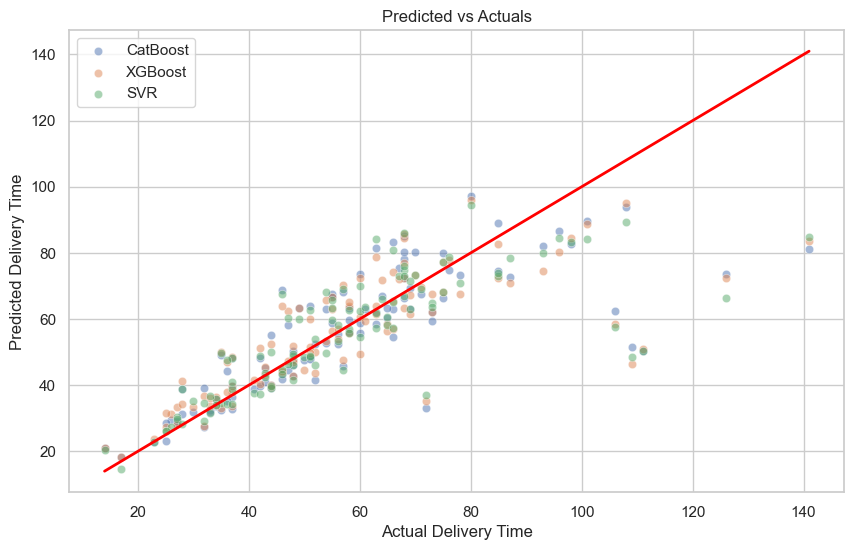

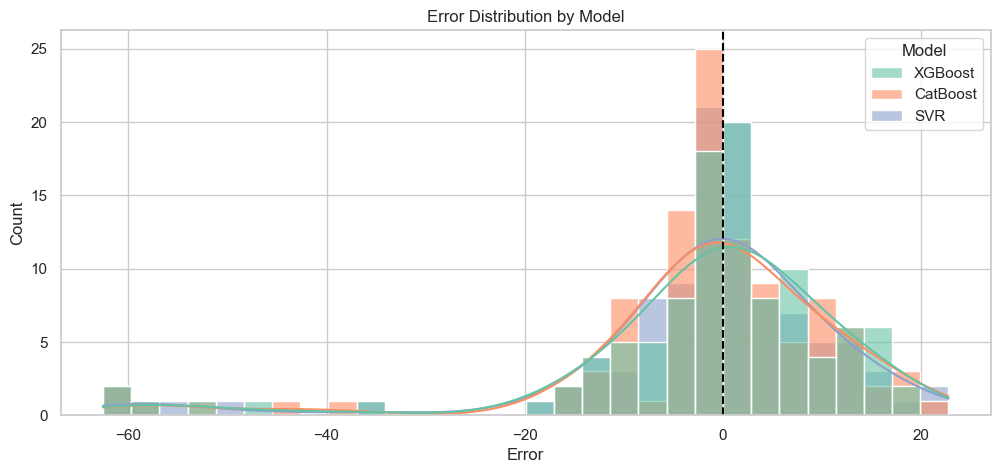

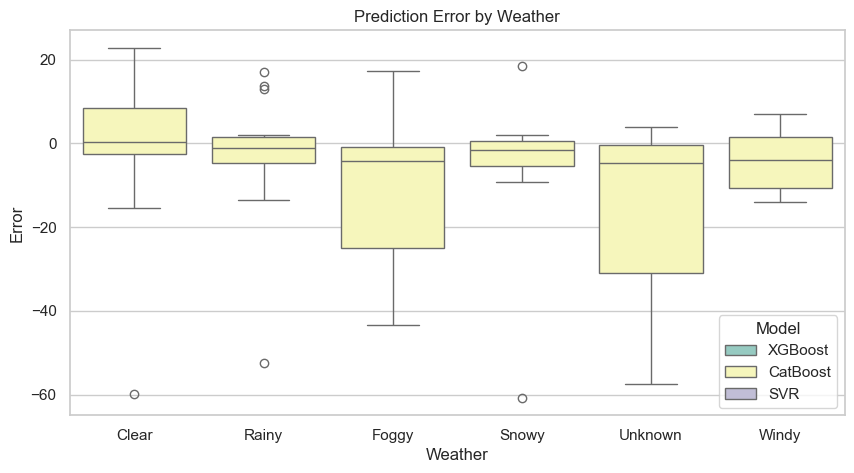

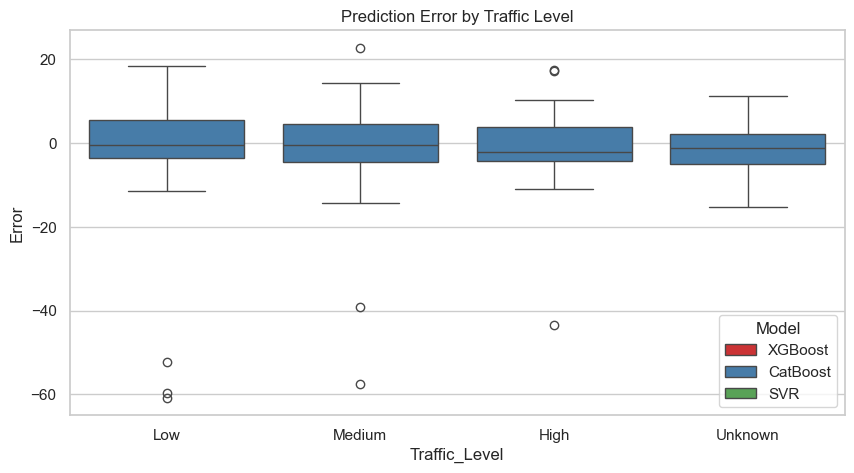

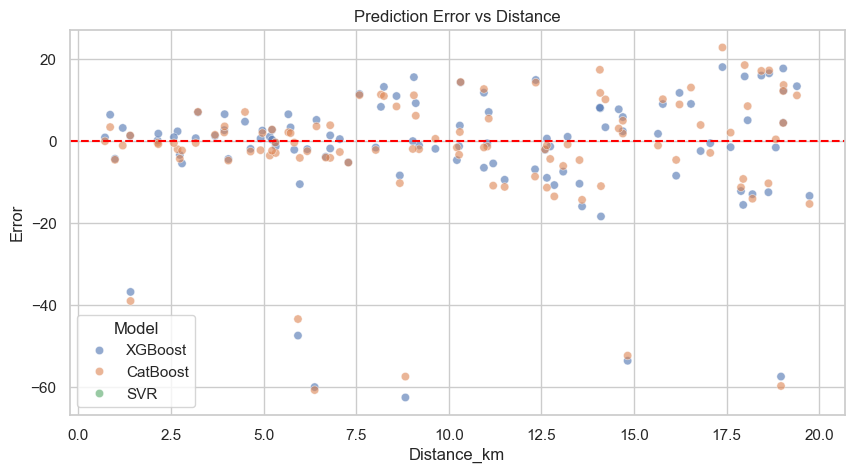

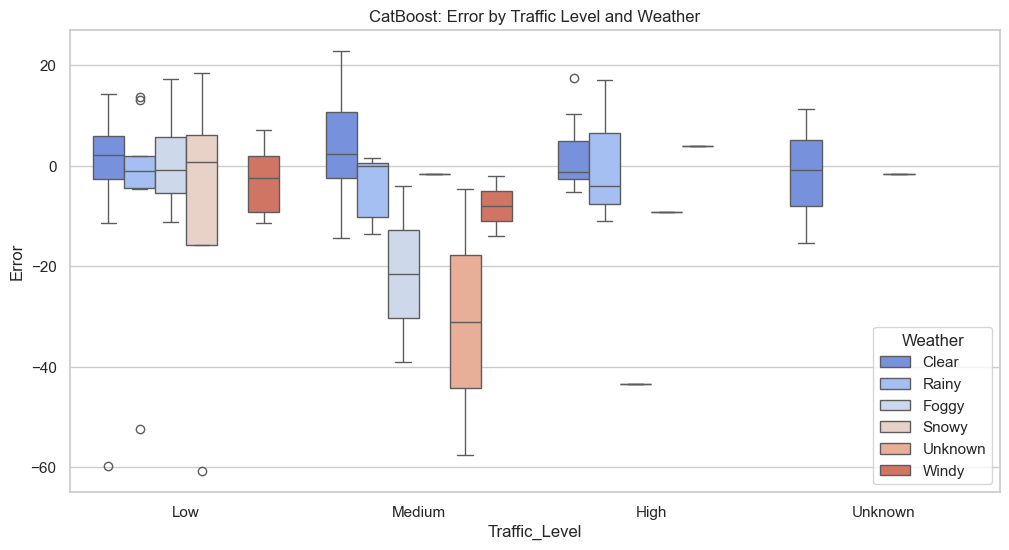

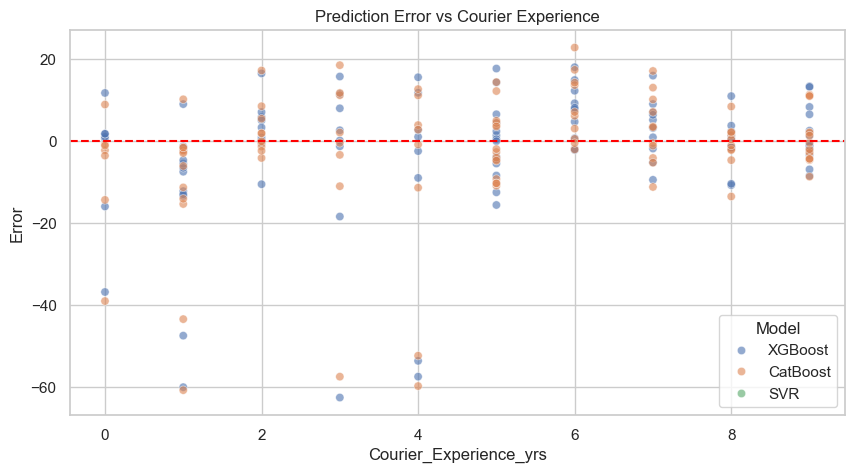

In [26]:

config = Global.load_config()
output_dir = Path(Global.get_project_path(config["model"]["data_prep"]["path"], 0))

csv_files = list(output_dir.glob("*_predictions_vs_actuals.csv"))
eval_data = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

models_to_analyze = ["CatBoost", "XGBoost", "SVR"]
eval_data = eval_data[eval_data["Model"].isin(models_to_analyze)].copy()

eval_data['Error'] = eval_data['Predicted'] - eval_data['Actual']
eval_data['Abs_Error'] = eval_data['Error'].abs()

summary = eval_data.groupby("Model").apply(
    lambda df: pd.Series({
        "MAE": df['Abs_Error'].mean(),
        "RMSE": (df['Error']**2).mean()**0.5,
        "MAPE": (df['Abs_Error'] / df['Actual']).mean() * 100
    })
).reset_index()
print(summary)

sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
for model_name in models_to_analyze:
    df_model = eval_data[eval_data['Model'] == model_name]
    sns.scatterplot(x='Actual', y='Predicted', data=df_model, label=model_name, alpha=0.5)
plt.plot([eval_data['Actual'].min(), eval_data['Actual'].max()],
         [eval_data['Actual'].min(), eval_data['Actual'].max()],
         color='red', lw=2)
plt.title("Predicted vs Actuals")
plt.xlabel("Actual Delivery Time")
plt.ylabel("Predicted Delivery Time")
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(data=eval_data, x='Error', hue='Model', bins=30, kde=True, palette="Set2", alpha=0.6)
plt.axvline(0, color='black', linestyle='--')
plt.title("Error Distribution by Model")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='Weather', y='Error', hue='Model', data=eval_data, palette="Set3")
plt.title("Prediction Error by Weather")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='Traffic_Level', y='Error', hue='Model', data=eval_data, palette="Set1")
plt.title("Prediction Error by Traffic Level")
plt.show()

plt.figure(figsize=(10,5))
sns.scatterplot(x='Distance_km', y='Error', hue='Model', data=eval_data, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Prediction Error vs Distance")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(x='Traffic_Level', y='Error', hue='Weather', data=eval_data[eval_data['Model']=="CatBoost"], palette="coolwarm")
plt.title("CatBoost: Error by Traffic Level and Weather")
plt.show()

plt.figure(figsize=(10,5))
sns.scatterplot(x='Courier_Experience_yrs', y='Error', hue='Model', data=eval_data, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Prediction Error vs Courier Experience")
plt.show()


/var/folders/9j/h9cvqwwx1c78h1ymykk4wh6w0000gn/T/ipykernel_13555/3389103212.py:20: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



R² per Model:
                   Model        R2
0               CatBoost  0.595928
1                    KRR  0.550552
2                  Lasso  0.568484
3       LinearRegression  0.568989
4           MLPRegressor -1.280896
5  RandomForestRegressor  0.539737
6                  Ridge  0.569104
7                    SVR  0.585845
8                XGBoost  0.584831
9                    kNN  0.526544


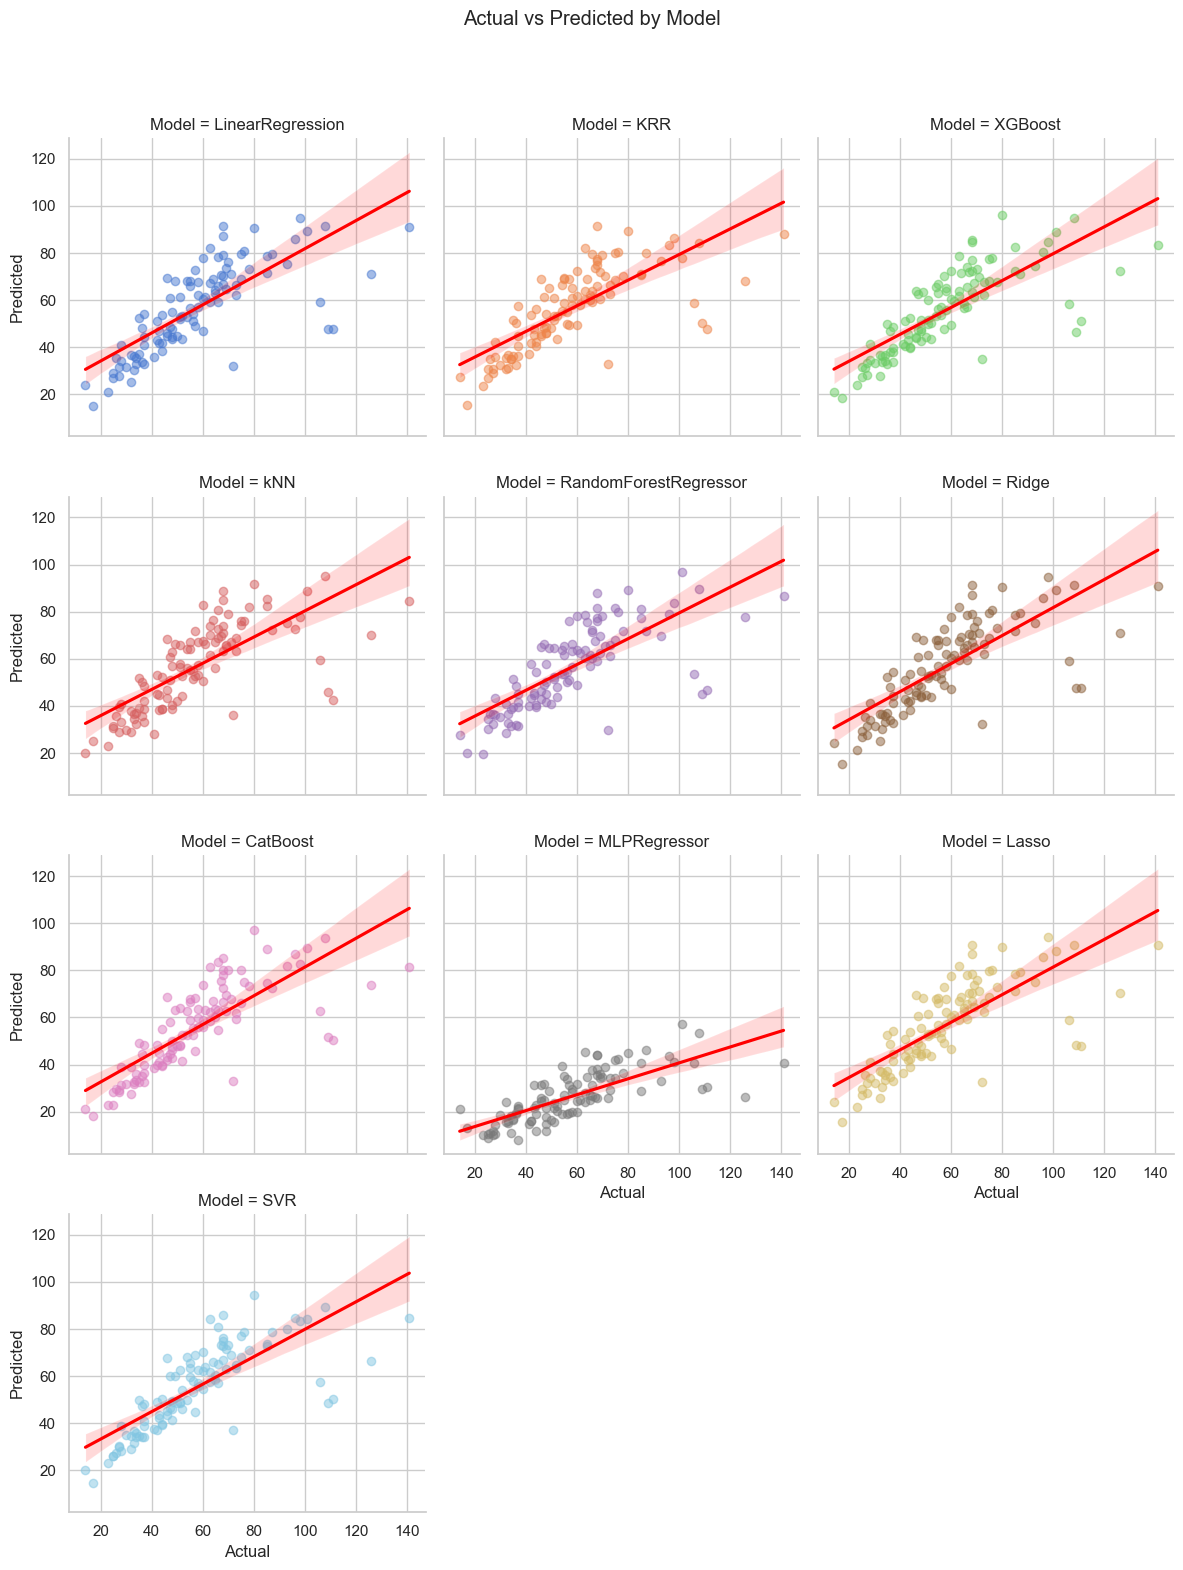

/var/folders/9j/h9cvqwwx1c78h1ymykk4wh6w0000gn/T/ipykernel_13555/3389103212.py:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




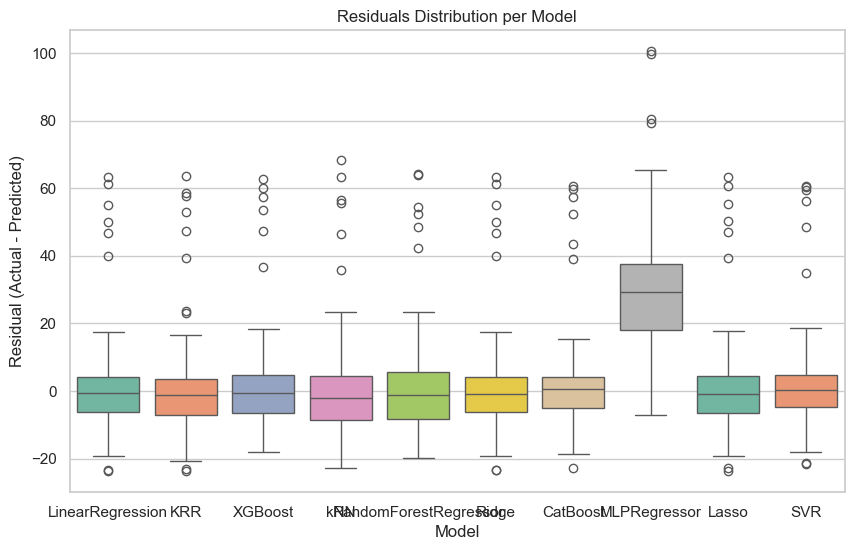

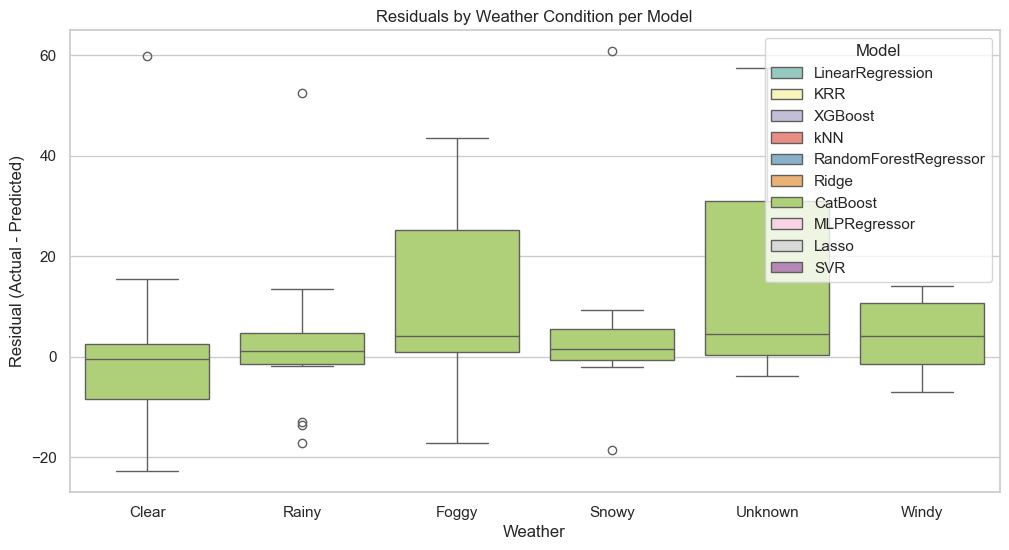

In [29]:

config = Global.load_config()
output_dir = Path(Global.get_project_path(config["model"]["data_prep"]["path"], 0))

csv_files = list(output_dir.glob("*_predictions_vs_actuals.csv"))
eval_data = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)


r2_summary = eval_data.groupby("Model").apply(
    lambda df: r2_score(df["Actual"], df["Predicted"])
).reset_index(name="R2")

print("R² per Model:")
print(r2_summary)


sns.set(style="whitegrid", palette="muted")
g = sns.lmplot(
    data=eval_data, x="Actual", y="Predicted",
    hue="Model", col="Model", col_wrap=3,
    height=4, scatter_kws={"alpha":0.5}, line_kws={"color":"red"}
)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Actual vs Predicted by Model")
plt.show()


eval_data["Residual"] = eval_data["Actual"] - eval_data["Predicted"]
plt.figure(figsize=(10,6))
sns.boxplot(data=eval_data, x="Model", y="Residual", palette="Set2")
plt.title("Residuals Distribution per Model")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

if "Weather" in eval_data.columns:
    plt.figure(figsize=(12,6))
    sns.boxplot(data=eval_data, x="Weather", y="Residual", hue="Model", palette="Set3")
    plt.title("Residuals by Weather Condition per Model")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.show()


Loaded 105 prediction records for CatBoost.


,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Actual,Predicted,Model
0,2.68,Clear,Low,Morning,Bike,16,8.0,25,22.978727,CatBoost
1,6.18,Clear,Medium,Evening,Bike,9,9.0,35,32.506288,CatBoost
2,9.11,Clear,Low,Afternoon,Bike,19,6.0,42,48.169010,CatBoost
3,4.97,Rainy,Low,Evening,Bike,17,9.0,34,35.942627,CatBoost
4,18.65,Foggy,Low,Night,Car,19,2.0,68,85.213206,CatBoost



Model Performance Summary (CatBoost)
MAE : 8.85 min
RMSE: 14.88 min
R²  : 0.596


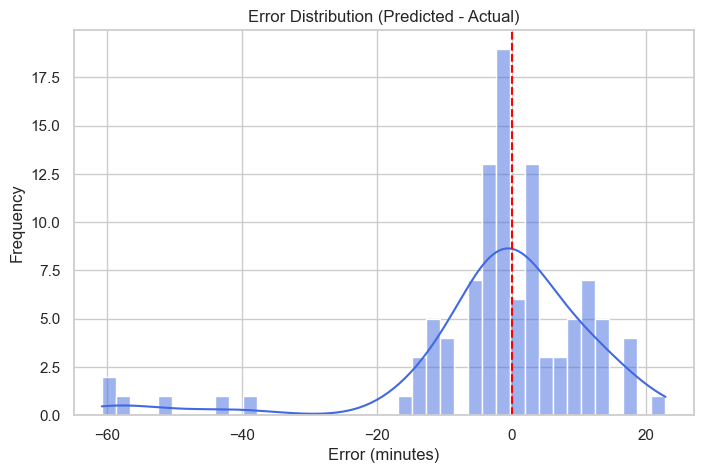

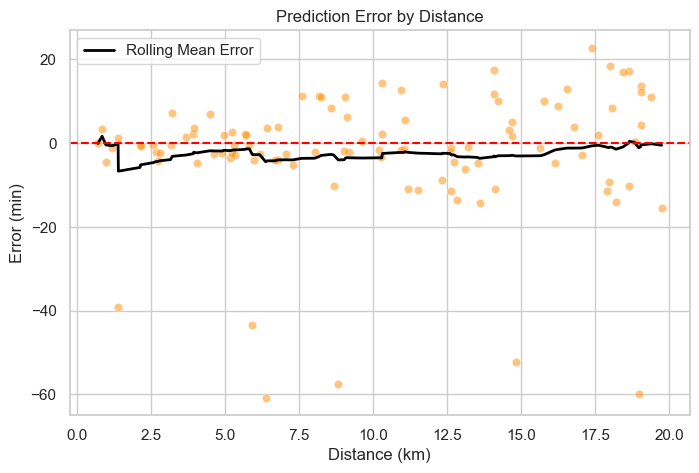

,Distance_km,Abs_Error
0,"(0, 2]",8.258723
1,"(2, 5]",2.732992
2,"(5, 10]",9.482135
3,"(10, 20]",10.398539
4,"(20, 50]",nan


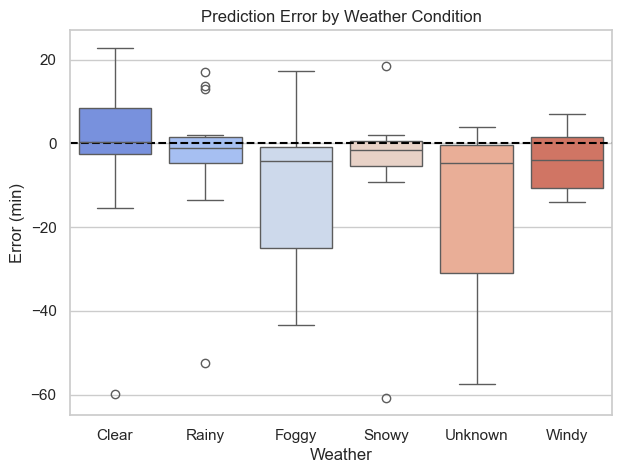


Deliveries > 50 minutes: 61 (58.1% of total)


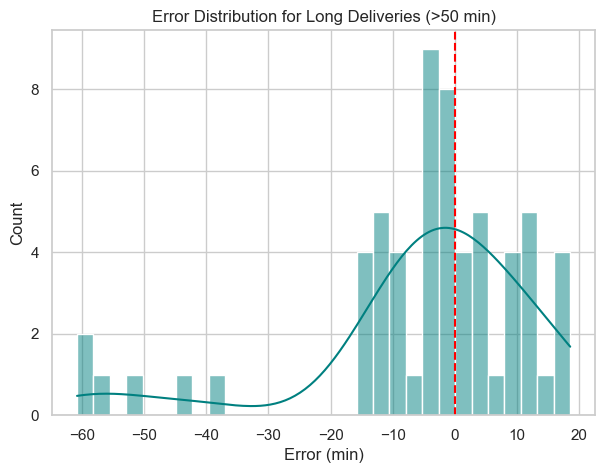

,MAE_long,RMSE_long
0,11.910777,18.712533


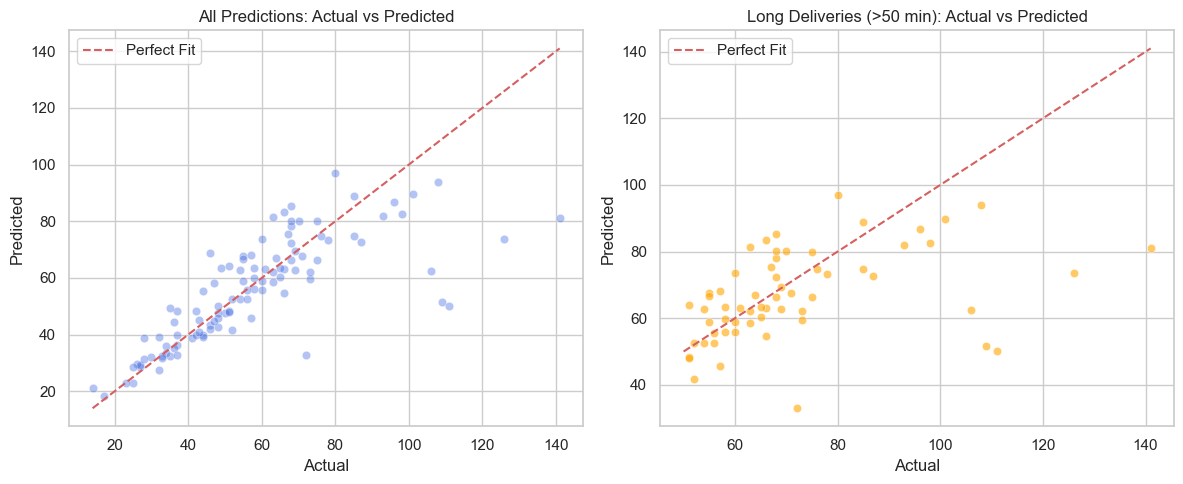

In [33]:
config = Global.load_config()
output_dir = Path(Global.get_project_path(config["model"]["data_prep"]["path"], 0))

catboost_file = next(output_dir.glob("*CatBoost*_predictions_vs_actuals.csv"))
df = pd.read_csv(catboost_file)

print(f"Loaded {df.shape[0]:,} prediction records for CatBoost.")
display(df.head())

df["Error"] = df["Predicted"] - df["Actual"]
df["Abs_Error"] = df["Error"].abs()

mae = mean_absolute_error(df["Actual"], df["Predicted"])
mse = mean_squared_error(df["Actual"], df["Predicted"])
rmse = np.sqrt(mse)
r2 = r2_score(df["Actual"], df["Predicted"])

print(f"\nModel Performance Summary (CatBoost)")
print(f"MAE : {mae:.2f} min")
print(f"RMSE: {rmse:.2f} min")
print(f"R²  : {r2:.3f}")

plt.figure(figsize=(8,5))
sns.histplot(df["Error"], kde=True, bins=40, color="royalblue")
plt.title("Error Distribution (Predicted - Actual)")
plt.xlabel("Error (minutes)")
plt.ylabel("Frequency")
plt.axvline(0, color="red", linestyle="--")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x="Distance_km", y="Error", alpha=0.5, color="darkorange")

df_sorted = df.sort_values("Distance_km").reset_index(drop=True)
rolling_mean = df_sorted["Error"].rolling(window=50, min_periods=1).mean()
sns.lineplot(x=df_sorted["Distance_km"], y=rolling_mean, color="black", lw=2, label="Rolling Mean Error")
plt.title("Prediction Error by Distance")
plt.xlabel("Distance (km)")
plt.ylabel("Error (min)")
plt.axhline(0, color="red", linestyle="--")
plt.legend()
plt.show()

error_by_distance = df.groupby(pd.cut(df["Distance_km"], bins=[0,2,5,10,20,50]))["Abs_Error"].mean().reset_index()
display(error_by_distance.style.background_gradient(cmap="Blues").set_caption("Average Absolute Error by Distance Range"))

plt.figure(figsize=(7,5))
sns.boxplot(data=df, x="Weather", y="Error", palette="coolwarm")
plt.title("Prediction Error by Weather Condition")
plt.xlabel("Weather")
plt.ylabel("Error (min)")
plt.axhline(0, color="black", linestyle="--")
plt.show()

error_by_weather = (
    df.groupby("Weather")[["Abs_Error"]]
    .agg(["mean", "median", "count"])
    .sort_values(("Abs_Error", "mean"), ascending=False)
)
display(error_by_weather.style.background_gradient(cmap="Reds").set_caption("Error Summary by Weather"))

long_deliveries = df[df["Actual"] > 50].copy()
print(f"\nDeliveries > 50 minutes: {len(long_deliveries)} ({len(long_deliveries)/len(df)*100:.1f}% of total)")

plt.figure(figsize=(7,5))
sns.histplot(long_deliveries["Error"], bins=30, kde=True, color="teal")
plt.title("Error Distribution for Long Deliveries (>50 min)")
plt.xlabel("Error (min)")
plt.axvline(0, color="red", linestyle="--")
plt.show()

mae_long = mean_absolute_error(long_deliveries["Actual"], long_deliveries["Predicted"])
mse_long = mean_squared_error(long_deliveries["Actual"], long_deliveries["Predicted"])
rmse_long = np.sqrt(mse_long)
error_long_summary = {
    "MAE_long": mae_long,
    "RMSE_long": rmse_long
}
display(pd.DataFrame([error_long_summary]).style.set_caption("Long Deliveries Error Summary"))

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.scatterplot(data=df, x="Actual", y="Predicted", alpha=0.4, ax=axes[0], color="royalblue")
axes[0].plot([df["Actual"].min(), df["Actual"].max()],
             [df["Actual"].min(), df["Actual"].max()],
             "r--", label="Perfect Fit")
axes[0].set_title("All Predictions: Actual vs Predicted")
axes[0].legend()

sns.scatterplot(data=long_deliveries, x="Actual", y="Predicted", alpha=0.6, ax=axes[1], color="orange")
axes[1].plot([50, long_deliveries["Actual"].max()],
             [50, long_deliveries["Actual"].max()],
             "r--", label="Perfect Fit")
axes[1].set_title("Long Deliveries (>50 min): Actual vs Predicted")
axes[1].legend()

plt.tight_layout()
plt.show()
